# EE4C12-Epileptic-Seizure-Detection-using-EEG


    
Group 16 Members:

    1. Zhixuan Ge  
    2. Yanqi Hong 

## 1. Program Preparation

### 1.1 Import Packages

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_curve, precision_recall_curve, PrecisionRecallDisplay, roc_auc_score, RocCurveDisplay, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

# from sklearn.utils.validation import check_missing_values
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
# from sklearn.datasets import make_classification
# from collections import Counter

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
device = "cuda"
#device = "cpu"

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

### 1.2 Import Data

In [2]:
#load data on Yanqi Hong's computer
data = pd.read_csv('E:\DATA\TUD\Master\TUD_Master_Y1\Q1\EE4C12 Machine Learning For Electrical Engineering\CodeLab\Project\S&S_SZD (1)\Data\Project_Data_EE4C12_S&S_SZD.csv')
data

,Patient,annotation,min|FP1-F7,min|F7-T3,min|T3-T5,min|T5-O1,min|FP2-F8,min|F8-T4,min|T4-T6,min|T6-O2,...,norm_power_HF|CZ-C4,norm_power_HF|C4-T4,norm_power_HF|FP1-F3,norm_power_HF|F3-C3,norm_power_HF|C3-P3,norm_power_HF|P3-O1,norm_power_HF|FP2-F4,norm_power_HF|F4-C4,norm_power_HF|C4-P4,norm_power_HF|P4-O2
0,258,1,50,61,57,53,39,35,39,35,...,0.016087,0.066920,0.102402,0.481384,0.690787,0.154544,0.062533,0.046460,0.066575,0.086999
1,258,1,48,62,60,46,38,35,39,33,...,0.024006,0.064857,0.031791,0.225788,0.409987,0.184671,0.071133,0.022369,0.079494,0.047536
2,258,1,51,60,59,45,38,36,40,36,...,0.037326,0.100177,0.050009,0.622584,0.394504,0.225516,0.050673,0.044906,0.102142,0.068105
3,258,1,49,58,56,42,36,36,41,37,...,0.027546,0.107883,0.014017,0.359140,0.276964,0.104977,0.018042,0.079467,0.078255,0.089385
4,258,1,45,57,61,41,35,37,41,37,...,0.036820,0.182520,0.031397,0.328354,0.156929,0.151952,0.047532,0.135071,0.098320,0.137701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55451,11580,-1,75,73,81,80,66,80,77,75,...,0.244334,0.625396,0.023821,0.058277,0.083594,0.114426,0.119654,0.295364,0.185930,0.199585
55452,11580,-1,74,74,77,71,79,75,82,77,...,0.588236,0.743060,0.076294,0.332341,0.228458,0.170603,0.351418,0.638666,0.490806,0.307429
55453,11580,-1,72,76,72,73,74,76,80,76,...,0.296041,0.770194,0.041190,0.090919,0.186074,0.216797,0.231053,0.770637,0.285257,0.413382
55454,11580,-1,77,82,74,75,82,85,80,76,...,0.440360,0.720855,0.026959,0.026340,0.077674,0.269610,0.186769,0.790173,0.473615,0.415771


In [3]:
# # load data on Zhixuan's computer
# data = pd.read_csv('D:\\User\Zhixuan Ge\Onedrive TUDelft\OneDrive - Delft University of Technology\Courses\ML for EE\SZD\S&S_SZD\Project_Data_EE4C12_S&S_SZD.csv')
# data

## 2. Data Preprocessing

### 2.1 Train-Test Split

In [43]:
# Not applied for the moment
# x is the features, y is the label
y = np.int32(data['annotation'].values)
X = data.iloc[:, 2:].values

#split the data into training and testing
Shuffle_state = 42
test_size = 0.25
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=Shuffle_state)

print(X_train.shape)
print(X_test.shape)

#pca
# from sklearn.decomposition import PCA
# pca = PCA(n_components=2)
# pca.fit(X_train)
# X_train =pca.transform(X_train)
# X_test =pca.transform(X_test)
# print(X_train.shape)
# print(X_test.shape)

#k fold cross validation

(41592, 360)
(13864, 360)


In [44]:
#k fold cross validation
def Kfold_split(X_train, y_train, Shuffle_state):   # Split the data into training and validation sets
    #example : X_k_train, y_k_train, X_k_val, y_k_val = Kfold_split(X_train, y_train, Shuffle_state)
    kf = KFold(n_splits=5, random_state=Shuffle_state, shuffle=True)
    kf.get_n_splits(X_train)
    X_k_train = []
    y_k_train = []
    X_k_val = []
    y_k_val = []
    for train_index, val_index in kf.split(X_train):  # Split the data into training and validation sets
        X_k_train.append(X_train[train_index])
        y_k_train.append(y_train[train_index])
        X_k_val.append(X_train[val_index])
        y_k_val.append(y_train[val_index])
    return X_k_train, y_k_train, X_k_val, y_k_val



### 2.2 Scaling

In [45]:
# clf_etc = ExtraTreesClassifier(random_state=Shuffle_state).fit(X_train, y_train)
# # y_pred = clf_etc.predict(X_test)
# feature_importances = clf_etc.feature_importances_
# plt.bar(range(len(feature_importances)), feature_importances)
# plt.show()
# important_feature_indices=np.argsort(feature_importances)[::-1]
# for i in range(0,len(important_feature_indices)):
#     X_train[important_feature_indices[i]]= X_train[important_feature_indices[i]]*feature_importances[important_feature_indices[i]]
#     # X_test[important_feature_indices[i]]= X_test[important_feature_indices[i]]*feature_importances[important_feature_indices[i]]
    

#standardize the data
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 2.3 Oversampling and Undersampling

In [46]:
num_zero=np.sum(y_train==0)
num_one=np.sum(y_train==1)
num_negatives_one=np.sum(y_train==-1)
print('The number of 0 is', num_zero)
print('The number of 1 is', num_one)
print('The number of -1 is', num_negatives_one)

#undersampling
# from imblearn.under_sampling import RandomUnderSampler
# rus = RandomUnderSampler(random_state=Shuffle_state)
# X_train, y_train = rus.fit_resample(X_train, y_train)

# oversampling
sm = SMOTE(random_state=Shuffle_state)
X_train_scaled, y_train = sm.fit_resample(X_train_scaled, y_train)

#Combination of over- and under-sampling
# smt = SMOTETomek(random_state=Shuffle_state)
# X_train_scaled, y_train = smt.fit_resample(X_train_scaled, y_train)

num_zero=np.sum(y_train==0)
num_one=np.sum(y_train==1)
num_negatives_one=np.sum(y_train==-1)

print('The number of 0 is', num_zero)
print('The number of 1 is', num_one)
print('The number of -1 is', num_negatives_one)

The number of 0 is 1469
The number of 1 is 18177
The number of -1 is 21946
The number of 0 is 21946
The number of 1 is 21946
The number of -1 is 21946


In [29]:
y = np.int32(data['annotation'].values)
X = data.iloc[:, 2:].values

scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

In [30]:
n_p = data['annotation'].value_counts()[1]
n_n = data['annotation'].value_counts()[-1]
n_z = data['annotation'].value_counts()[0]

weights = np.array([n_n, n_z, n_p])
weights = weights / weights.sum()
weights = 1 / weights
weights = weights / weights.sum()

weights = {-1:weights[0], 0:weights[1], 1:weights[2]}

print(weights)

{-1: 0.05863727895765303, 0: 0.8704602962506767, 1: 0.07090242479167017}


## 3. Model Training

### 3.1 Try 1: logistic regression

In [31]:
#Logistic regression
clf_lr = LogisticRegression(max_iter=1000, class_weight=weights).fit(X_train, y_train)
y_pred = clf_lr.predict(X_test)

C:\Users\skyho\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [32]:
#Performance metrics
Accuracy_LR = accuracy_score(y_test, y_pred)
F1_LR = accuracy_score(y_test, y_pred)
Precision_LR = accuracy_score(y_test, y_pred)
Recall_LR = accuracy_score(y_test, y_pred)
print("Accuracy: " + str(Accuracy_LR))
print("F1 score: " + str(F1_LR))
print("Recall score: " + str(Recall_LR))
print("Precision score: " + str(Precision_LR))

Accuracy: 0.4337132140796307
F1 score: 0.4337132140796307
Recall score: 0.4337132140796307
Precision score: 0.4337132140796307


In [33]:
# not possible for multi-classification
'''#ROC curve

y_score_train = clf_lr.decision_function(X_train)
y_score_test = clf_lr.decision_function(X_test)
fpr_train, tpr_train, _ = roc_curve(y_train, y_score_train, pos_label=clf_lr.classes_[1])
fpr_test, tpr_test, _ = roc_curve(y_test, y_score_test, pos_label=clf_lr.classes_[1])

ax = plt.gca()
train_disp = RocCurveDisplay(fpr=fpr_train, tpr=tpr_train)
train_disp.plot(ax, name='Train')

test_disp = RocCurveDisplay(fpr=fpr_test, tpr=tpr_test)
test_disp.plot(ax, name='Test')

plt.legend()
plt.show()'''

"#ROC curve\n\ny_score_train = clf_lr.decision_function(X_train)\ny_score_test = clf_lr.decision_function(X_test)\nfpr_train, tpr_train, _ = roc_curve(y_train, y_score_train, pos_label=clf_lr.classes_[1])\nfpr_test, tpr_test, _ = roc_curve(y_test, y_score_test, pos_label=clf_lr.classes_[1])\n\nax = plt.gca()\ntrain_disp = RocCurveDisplay(fpr=fpr_train, tpr=tpr_train)\ntrain_disp.plot(ax, name='Train')\n\ntest_disp = RocCurveDisplay(fpr=fpr_test, tpr=tpr_test)\ntest_disp.plot(ax, name='Test')\n\nplt.legend()\nplt.show()"

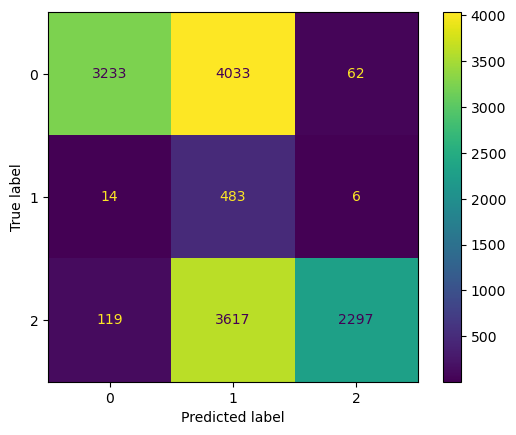

In [34]:
#Confusion Matrix
cm_2c = confusion_matrix(y_test, y_pred)
cm_display_2c = ConfusionMatrixDisplay(cm_2c).plot()
plt.show()

In [75]:
clf_svm = svm.SVC(kernel='linear', max_iter=2000,random_state=Shuffle_state, verbose=1, class_weight=weights).fit(X_train, y_train)
y_pred = clf_svm.predict(X_test)

ValueError: Found input variables with inconsistent numbers of samples: [41592, 65684]

In [36]:
#Performance metrics
Accuracy_LR = accuracy_score(y_test, y_pred)
F1_LR = accuracy_score(y_test, y_pred)
Precision_LR = accuracy_score(y_test, y_pred)
Recall_LR = accuracy_score(y_test, y_pred)
print("Accuracy: " + str(Accuracy_LR))
print("F1 score: " + str(F1_LR))
print("Recall score: " + str(Recall_LR))
print("Precision score: " + str(Precision_LR))

Accuracy: 0.407530294287363
F1 score: 0.407530294287363
Recall score: 0.407530294287363
Precision score: 0.407530294287363


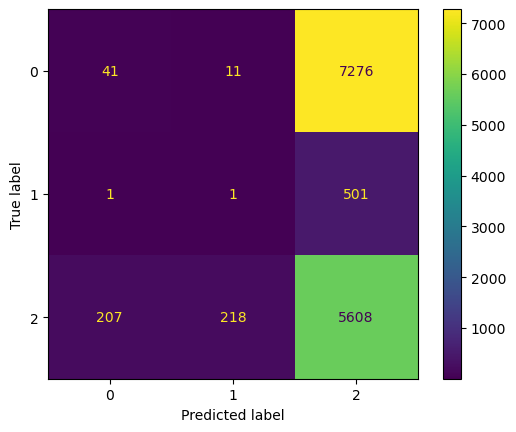

In [37]:
#Confusion Matrix
cm_2c = confusion_matrix(y_test, y_pred)
cm_display_2c = ConfusionMatrixDisplay(cm_2c).plot()
plt.show()

### 3.2 Try 2: mlp (sklearn)


In [17]:
# hl_size = (128, 64,64)
# #hl_size = (256, 256, 256, 128, 64)
# clf_mlp = MLPClassifier(hidden_layer_sizes=hl_size, activation='relu', solver='adam',
#                         alpha=0.0001, max_iter=1000, shuffle=True, random_state=Shuffle_state, verbose=True)
# clf_mlp.fit(X_train_scaled, y_train)
# y_pred = clf_mlp.predict(X_test_scaled)

mlp = MLPClassifier()

param_dist = {"hidden_layer_sizes": [(50,), (100,), (150,), (200,)],
              "activation": ["logistic", "tanh", "relu"],
              "solver": ["sgd", "adam"],
              "alpha": [0.0001, 0.001, 0.01],
              "learning_rate": ["constant", "adaptive"]}

# run randomized search
n_iter_search = 10
random_search = RandomizedSearchCV(mlp, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5, verbose=2, n_jobs=8)
random_search.fit(X_train_scaled, y_train)
y_pred = random_search.predict(X_test_scaled)

print(random_search.best_params_)
print("Best score:", random_search.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [89]:
#Performance metrics
Accuracy_LR = accuracy_score(y_test, y_pred)
F1_LR = accuracy_score(y_test, y_pred)
Precision_LR = accuracy_score(y_test, y_pred)
Recall_LR = accuracy_score(y_test, y_pred)
print("Accuracy: " + str(Accuracy_LR))
print("F1 score: " + str(F1_LR))
print("Recall score: " + str(Recall_LR))
print("Precision score: " + str(Precision_LR))

Accuracy: 0.8711771494518177
F1 score: 0.8711771494518177
Recall score: 0.8711771494518177
Precision score: 0.8711771494518177


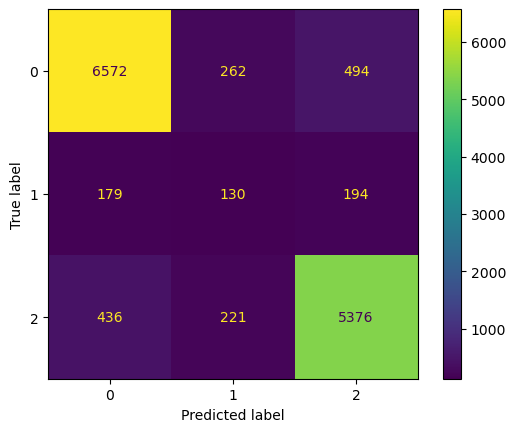

503
6033
7328


In [92]:
#Confusion Matrix
cm_2c = confusion_matrix(y_test, y_pred)
cm_display_2c = ConfusionMatrixDisplay(cm_2c).plot()
plt.show()


### 3.3 Try 3: Random Forest

In [7]:
rf = RandomForestClassifier()


param_dist = {"max_depth": [3, None],
              "max_features": np.arange(1, 10),
              "min_samples_split": np.arange(2, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy", "log_loss"]}

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(rf, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5, verbose=3, n_jobs=8)

random_search.fit(X_train_scaled, y_train)
y_pred = random_search.predict(X_test_scaled)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [8]:
#Performance metrics
Accuracy_LR = accuracy_score(y_test, y_pred)
F1_LR = accuracy_score(y_test, y_pred)
Precision_LR = accuracy_score(y_test, y_pred)
Recall_LR = accuracy_score(y_test, y_pred)
print("Accuracy: " + str(Accuracy_LR))
print("F1 score: " + str(F1_LR))
print("Recall score: " + str(Recall_LR))
print("Precision score: " + str(Precision_LR))

Accuracy: 0.8868291979226774
F1 score: 0.8868291979226774
Recall score: 0.8868291979226774
Precision score: 0.8868291979226774


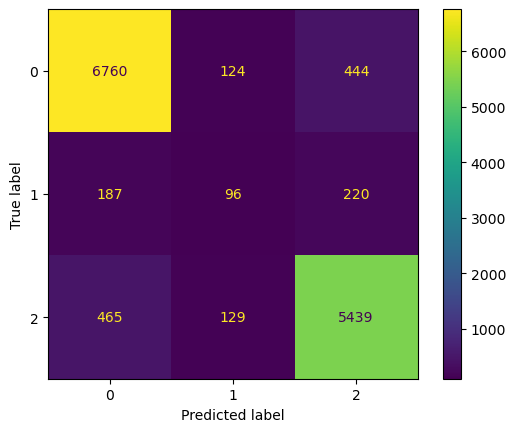

In [10]:
#Confusion Matrix
cm_2c = confusion_matrix(y_test, y_pred)
cm_display_2c = ConfusionMatrixDisplay(cm_2c).plot()
plt.show()

### 3.4  Try 4: DNN (PyTorch)

In [8]:
class Data_tensor(Dataset):
    def __init__(self, X, y):
        X = np.float32(X)
        X = torch.from_numpy(X)
        y = np.longlong(y) - y.min()
        y = torch.from_numpy(y)
        
        self.X = X.to(device)
        self.y = y.to(device)
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    


In [11]:
class DNN(nn.Module):
    def __init__(self, input_size=512, output_size=10):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, output_size)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

model = DNN(X.shape[1], 3).to(device)
print(model)

DNN(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=360, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=3, bias=True)
  )
)


In [12]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        print(pred.dtype)
        print(y.dtype)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [47]:
trainset_gpu = Data_tensor(X_train_scaled, y_train)
testset_gpu = Data_tensor(X_test_scaled, y_test)

batch_size = 1024
train_dataloader = DataLoader(trainset_gpu, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(testset_gpu, batch_size=batch_size, shuffle=False)

In [48]:
trainset_gpu[:][1].dtype

torch.int64

In [49]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
torch.float32
torch.int64
loss: 1.052481  [ 1024/65838]
torch.float32
torch.int64
torch.float32
torch.int64
torch.float32
torch.int64
torch.float32
torch.int64
torch.float32
torch.int64
torch.float32
torch.int64
torch.float32
torch.int64
torch.float32
torch.int64
torch.float32
torch.int64
torch.float32
torch.int64
torch.float32
torch.int64
torch.float32
torch.int64
torch.float32
torch.int64
torch.float32
torch.int64
torch.float32
torch.int64
torch.float32
torch.int64
torch.float32
torch.int64
torch.float32
torch.int64
torch.float32
torch.int64
torch.float32
torch.int64
torch.float32
torch.int64
torch.float32
torch.int64
torch.float32
torch.int64
torch.float32
torch.int64
torch.float32
torch.int64
torch.float32
torch.int64
torch.float32
torch.int64
torch.float32
torch.int64
torch.float32
torch.int64
torch.float32
torch.int64
torch.float32
torch.int64
torch.float32
torch.int64
torch.float32
torch.int64
torch.float32
torch.int64
torch.float32
torch.

In [50]:
pred(test_dataloader, model, loss_fn).shape

TypeError: 'numpy.ndarray' object is not callable

In [51]:
model.eval()
pred = model(test_dataloader.dataset[:][0]).detach().cpu().max(axis=1).indices.numpy()
true = test_dataloader.dataset[:][1].cpu().numpy()

In [52]:
#Performance metrics
Accuracy_LR = accuracy_score(true, pred)
F1_LR = accuracy_score(true, pred)
Precision_LR = accuracy_score(true, pred)
Recall_LR = accuracy_score(true, pred)
print("Accuracy: " + str(Accuracy_LR))
print("F1 score: " + str(F1_LR))
print("Recall score: " + str(Recall_LR))
print("Precision score: " + str(Precision_LR))

Accuracy: 0.8392960184650894
F1 score: 0.8392960184650894
Recall score: 0.8392960184650894
Precision score: 0.8392960184650894


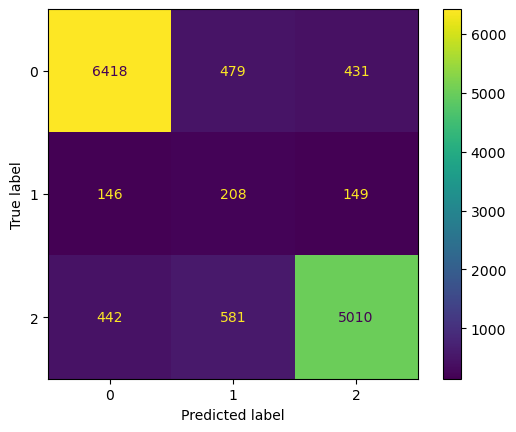

In [53]:
#Confusion Matrix
cm_2c = confusion_matrix(true, pred)
cm_display_2c = ConfusionMatrixDisplay(cm_2c).plot()
plt.show()

## 4. Model Evaluation